# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import cv2
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, TimeDistributed,Conv2D,MaxPooling2D,LSTM, Input,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet50
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Nadam, Adam, SGD

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 16

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,30,100,100,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100)).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]-104
                    batch_data[folder,idx,:,:,1] = image[:,:,1]-117
                    batch_data[folder,idx,:,:,2] = image[:,:,2]-123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,100,100,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100)).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0]-104
                    batch_data[folder,idx,:,:,1] = image[:,:,1]-117
                    batch_data[folder,idx,:,:,2] = image[:,:,2]-123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [6]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [7]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
#filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto',period=3)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

es = EarlyStopping(patience=10, restore_best_weights=True)

callbacks_list = [checkpoint, LR, es]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [8]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
## This model gave about 20% accuracy after 7 epochs using below architecture (No Transfer Learning)
'''
base_model = Sequential()
base_model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=(18,84,84,3)))
base_model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
base_model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
base_model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
base_model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
base_model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
base_model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
base_model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
base_model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
base_model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
base_model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
base_model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
base_model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
base_model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
base_model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
base_model.add(TimeDistributed(Flatten()))
 
base_model.add(Dropout(0.5))
base_model.add(LSTM(2048, return_sequences=True, dropout=0.3))
base_model.add(LSTM(1024, return_sequences=True, dropout=0.3))
base_model.add(LSTM(512, return_sequences=False, dropout=0.3))
base_model.add(Dense(128))
base_model.add(Dense(5, activation='softmax'))
base_model.summary()
'''

'\nbase_model = Sequential()\nbase_model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), activation=\'relu\', padding=\'same\'), input_shape=(18,84,84,3)))\nbase_model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation=\'relu\')))\nbase_model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))\n \nbase_model.add(TimeDistributed(Conv2D(64, (3,3), padding=\'same\', activation=\'relu\')))\nbase_model.add(TimeDistributed(Conv2D(64, (3,3), padding=\'same\', activation=\'relu\')))\nbase_model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))\n \nbase_model.add(TimeDistributed(Conv2D(128, (3,3), padding=\'same\', activation=\'relu\')))\nbase_model.add(TimeDistributed(Conv2D(128, (3,3), padding=\'same\', activation=\'relu\')))\nbase_model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))\n \nbase_model.add(TimeDistributed(Conv2D(256, (3,3), padding=\'same\', activation=\'relu\')))\nbase_model.add(TimeDistributed(Conv2D(256, (3,3), p

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
'''
optimiser = Adam()
base_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (base_model.summary())
'''

"\noptimiser = Adam()\nbase_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])\nprint (base_model.summary())\n"

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [11]:
'''
history = base_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
'''

'\nhistory = base_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, \n                    callbacks=callbacks_list, validation_data=val_generator, \n                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)\n'

In [12]:
'''
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Base CNN_LSTM Model (without Transfer Learning) accuracy')
plt.ylabel('Categorical accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
'''

"\n# summarize history for accuracy\nplt.plot(history.history['categorical_accuracy'])\nplt.plot(history.history['val_categorical_accuracy'])\nplt.title('Base CNN_LSTM Model (without Transfer Learning) accuracy')\nplt.ylabel('Categorical accuracy')\nplt.xlabel('epoch')\nplt.legend(['train', 'test'], loc='upper left')\nplt.show()\n# summarize history for loss\nplt.plot(history.history['loss'])\nplt.plot(history.history['val_loss'])\nplt.title('model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['train', 'test'], loc='upper left')\nplt.show()\n"

In [13]:
# Commenting out this model as I only want to run 3D CNN for now //remember to uncomment

video = Input(shape=(30,
                     100,
                     100,
                     3))
cnn_base = ResNet50(input_shape=(100,
                              100,
                              3),
                 weights="imagenet",
                 include_top=False)

##Commented below after suggestion from Harshul
cnn_out = GlobalAveragePooling2D()(cnn_base.output)
cnn = Model(cnn_base.input,cnn_out)


#cnn.trainable = False
split_at = 140
for layer in cnn.layers[:split_at]: layer.trainable = False
for layer in cnn.layers[split_at:]: layer.trainable = True


encoded_frames = TimeDistributed(cnn)(video)
##Added below after suggestion from Harshul

#cnn.add(TimeDistributed(BatchNormalization()))
#cnn.add(TimeDistributed(MaxPooling2D((2, 2))))
encoded_frames1 = TimeDistributed(Flatten())(encoded_frames)
##########
encoded_sequence = LSTM(4028, return_sequences=True)(encoded_frames1)
encoded_sequence1 = LSTM(2024,return_sequences=True)(encoded_sequence)
encoded_sequence2 = LSTM(1012)(encoded_sequence1)
hidden_layer = Dense(units=1024, activation="relu")(encoded_sequence2)
outputs = Dense(units=5, activation="softmax")(hidden_layer)
tl_cnn_lstm = Model([video], outputs)


2022-05-17 15:04:34.384353: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-17 15:04:34.384415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9788 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


In [14]:
optimiser = Adam()                 
tl_cnn_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (tl_cnn_lstm.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 100, 100, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 30, 2048)         23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 2048)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 30, 4028)          97912624  
                                                                 
 lstm_1 (LSTM)               (None, 30, 2024)          49005088  
                                                           

In [15]:
# Commenting out this model as I only want to run 3D CNN for now //remember to uncomment
history = tl_cnn_lstm.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 16
Epoch 1/20


2022-05-17 15:05:46.159638: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


42/42 [==============================] - 84s 2s/step - loss: 1.8166 - categorical_accuracy: 0.2066 - val_loss: 1.6034 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - 65s 2s/step - loss: 1.6275 - categorical_accuracy: 0.2036 - val_loss: 1.6582 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 1.5759 - categorical_accuracy: 0.2851
Epoch 00003: val_loss improved from inf to 1.32932, saving model to model_init_2022-05-1715_04_33.551182/model-00003-1.57591-0.28507-1.32932-0.37000.h5
42/42 [==============================] - 66s 2s/step - loss: 1.5759 - categorical_accuracy: 0.2851 - val_loss: 1.3293 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 4/20
42/42 [==============================] - 65s 2s/step - loss: 1.4572 - categorical_accuracy: 0.3092 - val_loss: 2.6922 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 5/20
42/42 [==============================] - 65s 

#######################

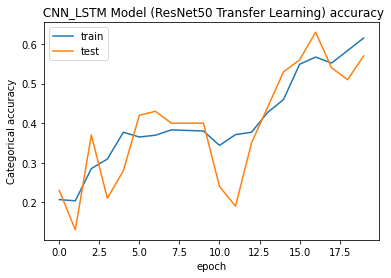

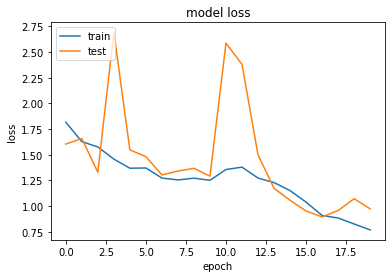

In [16]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title(' CNN_LSTM Model (ResNet50 Transfer Learning) accuracy')
plt.ylabel('Categorical accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:

#write your model here

threeD_cnn_model = Sequential()

threeD_cnn_model.add(Conv3D(16, (3,3,3), padding='same',input_shape=(30,100,100,3)))
threeD_cnn_model.add(BatchNormalization())
threeD_cnn_model.add(Activation('relu'))
threeD_cnn_model.add(MaxPooling3D(pool_size=(2,2,2)))
threeD_cnn_model.add(Dropout(0.3))

threeD_cnn_model.add(Conv3D(32, (3,3,3), padding='same'))
threeD_cnn_model.add(BatchNormalization())
threeD_cnn_model.add(Activation('relu'))
threeD_cnn_model.add(MaxPooling3D(pool_size=(2,2,2)))
threeD_cnn_model.add(Dropout(0.3))


threeD_cnn_model.add(Conv3D(64, (3,3,3), padding='same'))
threeD_cnn_model.add(BatchNormalization())
threeD_cnn_model.add(Activation('relu'))
threeD_cnn_model.add(MaxPooling3D(pool_size=(2,2,2)))
threeD_cnn_model.add(Dropout(0.3))


threeD_cnn_model.add(Conv3D(128, (3,3,3), padding='same'))
threeD_cnn_model.add(BatchNormalization())
threeD_cnn_model.add(Activation('relu'))
threeD_cnn_model.add(MaxPooling3D(pool_size=(2,2,2)))
threeD_cnn_model.add(Dropout(0.3))


threeD_cnn_model.add(Flatten())
threeD_cnn_model.add(Dropout(0.3))
threeD_cnn_model.add(Dense(256, activation='relu'))
threeD_cnn_model.add(Dropout(0.2))
threeD_cnn_model.add(Dense(5, activation='softmax'))

In [18]:
optimiser = Adam()

threeD_cnn_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (threeD_cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 100, 100, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 30, 100, 100, 16)  64       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 100, 100, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 50, 50, 16)   0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 50, 50, 16)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 50, 50, 32)    1

In [19]:
history = threeD_cnn_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 2.8472 - categorical_accuracy: 0.3484
Epoch 00001: val_loss did not improve from 0.95727
42/42 [==============================] - 65s 2s/step - loss: 2.8472 - categorical_accuracy: 0.3484 - val_loss: 11.2762 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - 64s 2s/step - loss: 1.2812 - categorical_accuracy: 0.4585 - val_loss: 3.2022 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/20
42/42 [==============================] - 65s 2s/step - loss: 1.1790 - categorical_accuracy: 0.4932 - val_loss: 0.9879 - val_categorical_accuracy: 0.5500 - lr: 0.0010
Epoch 4/20
42/42 [==============================] - ETA: 0s - loss: 0.9365 - categorical_accuracy: 0.6546
Epoch 00004: val_loss did not improve from 0.95727
42/42 [==============================] - 64s 2s/step - loss: 0.9365 - categorical_accuracy: 0.6546 - val_loss: 0.9894 - val_categorical_accuracy: 0.6900 - lr: 0.0010

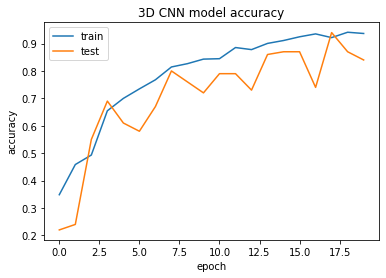

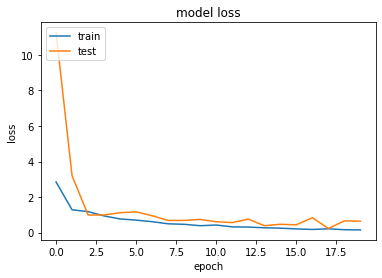

In [20]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('3D CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()